## **Introduction to Computer Vision (Fall 2021)**

### **Assignment 3: Crack detection**

Dataset: [download](https://drive.google.com/file/d/1oV7ZAJyaIqQICAR55Zq8Xf9i_nDgSKuh/view?usp=sharing)



### **Introduction**

Concrete structures such as bridge play an important role in ground transportation networks. While it is very labor intensive and dangerous for human to do the crack inspection. However, traditionally, concrete structure inspections are conducted manually by human operators with heavy and expensive mechanical equipment. It is logistically challenging, costly, and dangerous, especially when inspecting the substructure and superstructure in harsh environments that are hard and dangerous to be accessed by human operators. Therefore, it is very meaningful and significant for us to develop a fully autonomous intelligent unmanned aerial system for inspecting large-scale concrete structures and detecting the defects such as cracks. Most importantly, a significant module for UAV intelligent inspection system is to develop computer vision algorithms for processing images captured and detecting cracks and structural damages.

### **Data**
There are two classes only: positive (crack is present on image) and negative. Train images are located in folders named Positive/Negative. Test images are not provided.

Data are color images, each 227 by 227 pixels. There are 18,898 positive training samples and 18,811 negative training samples.



### **Anomaly detection**
Note: you are free to develop your own solution, here are some suggestions only.

You could build a binary classification network for this task, but we suggest you to build anomaly detection framework for solving this task. You can treat either positive images, either negative images as normal data.

Anomalies, also referred to as outliers, are defined as a set of patterns which significantly deviate from the normal or expected pattern.

We suggest you to build a CNN based autoencoder, that will be trained to reproduce normal patterns. The idea is, that the reproduction loss of a normal patterns will be much less than in abnormal patterns.

### **Autoencoder layers**
Here is the basic structure of autoencoder, that we propose to use. You are not obliged to use this one.

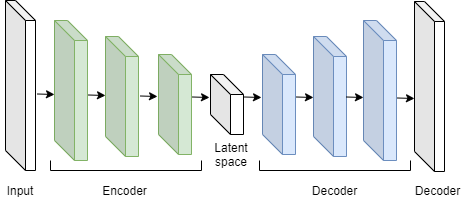

Encoder is a network that downsamples images into some latent space representation. Decoder upsamples from latent space to get the initial image. There are 3 layers in encoder and 3 layers in decoder. Try to play with the latent space size.

We suggest you to use tanh activation function for encoder and decoder layers.

Reconstruction Loss

Autoencoder is trained to minimize the following loss:

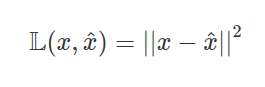

### **decision making**

After training the autoencoder to minimize the reconstruction loss for normal data samples, reconstruction loss threshold *t* is defined to make decision rule for separating normal and abnormal patterns. The full formulation of the anomaly detection using autoencoder can be expressed as follows:

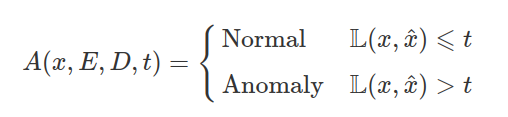

### **Grading policy**
You are free to experiment with data, methods and parameters, but the following things should be reflected in your code:

images of variable lenth should be allowed (make some preprocessing for that)


model will be evaluated using Precision and Recall (for both training dataset, and testing dataset)

USE RANDOM IMAGES FROM THE INTERNET TO TEST YOUR MODEL (10 to 15 images)
DO NOT FORGET TO INCLUDE THESE IMAGES WITH YOUR SUBMISSION

Your script should output predictions for test images in table (ypu can create a file predictions.csv) with the following format: file name, class label


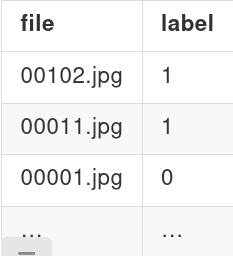



Class labels have the following mapping: positive - 1, negative - 0

**Important:** 0 points if we won’t be able to run your code

**Note:** Code quality will be evaluated. Up to -10% for not readable code.

**Note:** Your are free to use any framework (PyTorch, Keras, TensorFlow …).


# Introduction to Compucter Vision. Assignment 3


## Author: Alfiya Mussabekova

### Mount to google drive to get dataset and unzip it

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip 'drive/MyDrive/Dataset (3).zip' 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Dataset/Positive/13899.jpg  
  inflating: Dataset/Positive/13900.jpg  
  inflating: Dataset/Positive/13901.jpg  
  inflating: Dataset/Positive/13902.jpg  
  inflating: Dataset/Positive/13903.jpg  
  inflating: Dataset/Positive/13904.jpg  
  inflating: Dataset/Positive/13905.jpg  
  inflating: Dataset/Positive/13906.jpg  
  inflating: Dataset/Positive/13907.jpg  
  inflating: Dataset/Positive/13908.jpg  
  inflating: Dataset/Positive/13909.jpg  
  inflating: Dataset/Positive/13910.jpg  
  inflating: Dataset/Positive/13911.jpg  
  inflating: Dataset/Positive/13912.jpg  
  inflating: Dataset/Positive/13913.jpg  
  inflating: Dataset/Positive/13914.jpg  
  inflating: Dataset/Positive/13915.jpg  
  inflating: Dataset/Positive/13916.jpg  
  inflating: Dataset/Positive/13917.jpg  
  inflating: Dataset/Positive/13918.jpg  
  inflating: Dataset/Positive/13919.jpg  
  inflating: Dataset/Positive/13920.jpg  
  inflat

### Import needed libraries

In [11]:
import numpy as np
import torch
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
from PIL import Image
from sklearn.metrics import recall_score, precision_score, f1_score
from os import listdir
from os.path import isfile, join
%matplotlib inline

### Define datasets and dataloader



In [3]:
class MyDataset(Dataset):
  def __init__(self, root_dir, label, transform=None):
    self.root_dir = Path(root_dir)
    self.images = []
    self.label = label
    self.transform = transform
    for images in self.root_dir.iterdir():
      self.images.append(images)
      
  def __getitem__(self, idx):
    image = Image.open(self.images[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.label, str(self.images[idx])

  def __len__(self):
    return len(self.images)

In [4]:
# Define transform
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load datasets
root_dir = 'Dataset'
train_dataset = MyDataset(root_dir + '/Negative', 0, transform)
val_dataset = MyDataset(root_dir + '/Positive', 1, transform)

# Split dataset into train and validation
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset_neg = random_split(train_dataset, [train_len, val_len])
_, val_dataset_pos = random_split(val_dataset, [len(val_dataset) - val_len, val_len])
val_dataset = ConcatDataset([val_dataset_neg, val_dataset_pos])

# Define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

### Define model

**Encoder:**
  * Input: 3x256x256
  * conv1 output: 16x256x256
  * pooling output: 16x128x128
  * conv2 output: 4x64x64
  * pooling output: 4x32x32

**Decoder:**
  * Input: 4x32x32
  * 1st Layer Output: 4x64x64
  * 2nd Layer Output: 16x128x128
  * 3rd Layer Output: 3x256x256

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
       
        # encoder part
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
       
        # decoder part
        self.t_conv1 = nn.ConvTranspose2d(4, 4, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = torch.tanh(self.conv1(x))       # output 256x256
        x = self.pool(x)                    # 128x128
        x = torch.tanh(self.conv2(x))       # 64x64
        x = self.pool(x)                    # 32x32
        x = torch.tanh(self.t_conv1(x))     # 64x64
        x = torch.tanh(self.t_conv2(x))     # 128x128
        x = torch.sigmoid(self.t_conv3(x))  # 256x256
              
        return x

# device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

# Model
model = Model()
model.to(device)

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 4, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

### Define loss function, optimizer and learning rate scheduler

In [6]:
# Loss function
def loss_function(outputs, inputs):
  n = len(outputs)
  loss = torch.Tensor().to(device)
  for i in range(n):
    l = torch.unsqueeze(torch.mean(torch.square(torch.sub(outputs[i], inputs[i]))), 0)
    # print(type(l), l)
    loss = torch.cat((loss, l))
  return loss
criterion = loss_function

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# LR Scheduler
scheduler = ReduceLROnPlateau(optimizer)

### Train model

In [7]:
def train_one_epoch(model, optimizer, dataloader, criterion, epoch):
  model.train()
  total_loss = 0.0
  running_loss = 0.0
  for i, (images, labels, _) in enumerate(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = torch.mean(criterion(outputs, images))

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    running_loss += loss.item()

    if i % 100 == 99:
      print(f'Epoch: {epoch + 1}\n\tBatches seen: {i + 1}\n\tSamples seen: {(i + 1) * dataloader.batch_size}\n\tRunning loss: {running_loss / 100}')
      running_loss = 0.0  

  return total_loss / len(dataloader)

In [8]:
def evaluate(model, optimizer, dataloader, threshold, criterion, epoch):
  model.eval()
  losses = []
  recall = []
  precision = []
  f1 = []
  for i, (images, labels, _) in enumerate(dataloader):
    images = images.to(device)
    
    with torch.no_grad():
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, images)
      y_pred = []
      for l in loss:
        if l > threshold:
          y_pred.append(1)
        else:
          y_pred.append(0)
      recall.append(recall_score(labels, y_pred))
      precision.append(precision_score(labels, y_pred))
      f1.append(f1_score(labels, y_pred))
      losses.append(torch.mean(loss).cpu())

  loss = np.mean(losses)
  recall = np.mean(recall)
  precision = np.mean(precision)
  f1 = np.mean(f1)
  if epoch is not None:
    print(f'Epoch: {epoch + 1}')
  print(f'\tLoss: {loss}\n\tRecall: {recall}\n\tPrecision: {precision}\n\tF1 score: {f1}')  
  return loss, recall, precision, f1

In [10]:
# Number of epochs
epochs = 10

max_threshold = 0.0
th = []
for epoch in range(epochs):
  print(f'Starting epoch {epoch + 1}')
  train_loss = train_one_epoch(model, optimizer, train_dataloader, criterion, epoch)
  threshold = train_loss
  th.append(threshold)
  val_loss, val_recall, val_precision, val_f1 = evaluate(model, optimizer, val_dataloader, threshold, criterion, epoch)
  if threshold > max_threshold:
    max_threshold = threshold

  # scheduler step
  if scheduler is not None:
    scheduler.step(val_loss)

th = np.mean(th)
print(f'Finished training\nMax threshold:{max_threshold}\nMean threshold: {th}\nLast threshold: {threshold}')

Starting epoch 1
Epoch: 1
	Batches seen: 100
	Samples seen: 3200
	Running loss: 0.041936867143958806
Epoch: 1
	Batches seen: 200
	Samples seen: 6400
	Running loss: 0.041921610347926616
Epoch: 1
	Batches seen: 300
	Samples seen: 9600
	Running loss: 0.039310093056410554
Epoch: 1
	Batches seen: 400
	Samples seen: 12800
	Running loss: 0.03547823304310441
Epoch: 1
	Loss: 0.06435037404298782
	Recall: 0.8962344179074708
	Precision: 0.8371919791832765
	F1 score: 0.8620250946181616
Starting epoch 2
Epoch: 2
	Batches seen: 100
	Samples seen: 3200
	Running loss: 0.025577052012085915
Epoch: 2
	Batches seen: 200
	Samples seen: 6400
	Running loss: 0.024131385376676917
Epoch: 2
	Batches seen: 300
	Samples seen: 9600
	Running loss: 0.01777361460030079
Epoch: 2
	Batches seen: 400
	Samples seen: 12800
	Running loss: 0.014419686198234558
Epoch: 2
	Loss: 0.03729310259222984
	Recall: 0.9198325969564886
	Precision: 0.8850108097100743
	F1 score: 0.8989129465731872
Starting epoch 3
Epoch: 3
	Batches seen: 100

### Save model

In [15]:
torch.save(model, 'model.pt')

### Test model on validation dataset

In [16]:
data = []
recall = []
precision = []
f1 = []

for i, (images, labels, paths) in enumerate(val_dataloader):
  images = images.to(device)
  with torch.no_grad():
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, images)

    # find predicted labels using threshold
    y_pred = []
    for l in loss:
      if l > th:
        y_pred.append(1)
      else:
        y_pred.append(0)
    
    # save image name, presiction and true value
    for i, path in enumerate(paths):
      filename = path.split('/')[-1]
      data.append([filename, y_pred[i], labels[i].numpy()])
    
    # save metrics
    recall.append(recall_score(labels, y_pred))
    precision.append(precision_score(labels, y_pred))
    f1.append(f1_score(labels, y_pred))

# Save results to csv file
df = pd.DataFrame(data, columns=['Image Name', 'Prediction', 'True'])
df.to_csv('val_result.csv')

# Display metrics
print(f'RECALL: {np.mean(recall)}\nPRECISION: {np.mean(precision)}\nF1 SCORE: {np.mean(f1)}')

RECALL: 0.8466050297121657
PRECISION: 0.9616212093923696
F1 SCORE: 0.897333085564398


### Test on images from the internet

In [ ]:
!unzip 'Assignment3_test.zip'

In [19]:
# Load dataset
root_dir = 'Assignment3_test'
test_dataset_neg = MyDataset(root_dir + '/Negative', 0, transform)
test_dataset_pos = MyDataset(root_dir + '/Positive', 1, transform)
test_dataset = ConcatDataset([test_dataset_neg, test_dataset_pos])
# Define dataloader
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)

In [50]:
data = []
recall = []
precision = []
f1 = []

for i, (images, labels, paths) in enumerate(test_dataloader):
  images = images.to(device)
  with torch.no_grad():
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, images)
    # find predicted labels using threshold
    y_pred = []
    for l in loss:
      if l > th:
        y_pred.append(1)
      else:
        y_pred.append(0)

    # save image name, presiction and true value
    for i, path in enumerate(paths):
      filename = path.split('/')[-1]
      data.append([filename, y_pred[i], labels[i].numpy()])
    
    # save metrics
    recall.append(recall_score(labels, y_pred))
    precision.append(precision_score(labels, y_pred))
    f1.append(f1_score(labels, y_pred))


df = pd.DataFrame(data, columns=['Image Name', 'Prediction', 'True'])
df.to_csv('test_result.csv')

# Display metrics
print(f'RECALL: {np.mean(recall)}\nPRECISION: {np.mean(precision)}\nF1 SCORE: {np.mean(f1)}')

RECALL: 0.6666666666666666
PRECISION: 0.5714285714285714
F1 SCORE: 0.6153846153846153


### Detection of an image or directory of images

In [36]:
# function that returns what predictions for given path to images
def detection(path_to_img):
  # load model
  model = torch.load('model.pt')
  if os.path.isdir(path_to_img):
    images = sorted([join(path_to_img, f) for f in listdir(path_to_img) if isfile(join(path_to_img, f))])
  else:
    images = [path_to_img]

  preds = []
  for image in images:
    img = Image.open(image)
    img = torch.unsqueeze(transform(img), 0).to(device)
    output = model(img)
    loss = criterion(output, img)
    if loss[0] > th:
      preds.append(1)
    else:
      preds.append(0)
  return preds

### Test that detection function works

In [38]:
# for 1 image
path_to_image = './Assignment3_test/Positive/01.jpg'  # image is positive
detection(path_to_image)

[1]

In [37]:
# for directory of images
path_to_image = './Assignment3_test/Positive'         # all images are positive
detection(path_to_image)

[1, 0, 1, 1, 1, 0]